In [2]:
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
from keras import backend as K
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Input, BatchNormalization, LeakyReLU
from keras.layers.merge import concatenate
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
# from tensorflow import set_random_seed
import tensorflow as tf
from skimage.io import imread
from PIL import Image
from skimage.transform import resize
from tensorflow.keras.applications.vgg16 import VGG16
from keras.layers import *
import image_utils as iu


In [18]:
face_scrub_actors_data = os.path.join('data/faceScrub', 'facescrub_actors.txt')
face_scrub_actress_data = os.path.join(
    'data/faceScrub', 'facescrub_actresses.txt')
data_path = '/Users/ernestopoku-kwarteng/Documents/Pycharm Projects/Anaconda/Machine-Learning/HandWriting Detection/bounding-box-predictions/data'
actors_dir = os.path.join(data_path, 'actors')
actress_dir = os.path.join(data_path, 'actress')
images_path = ''


In [3]:
def load_image(path):
    return imread(path)


In [4]:
def read_image(path):
    img = Image.open(path).convert('RGB')
    return img
    #return np.asarray(img) YCbCr


In [5]:
def display_image(image):
    fig = plt.figure
    plt.imshow(image, cmap='brg')


In [6]:
def display_ycbcr_image(image):
    fig = plt.figure
    plt.imshow(image, cmap='YCbCr')


In [7]:
def get_all_files(path):
    onlyfiles = [f for f in os.listdir(
        path) if os.path.isfile(os.path.join(path, f))]
    return onlyfiles


In [23]:
actor_image_paths = get_all_files(actors_dir) 
actress_image_paths = get_all_files(actress_dir)

In [24]:
for x in range(len(actor_image_paths)):
    actor_image_paths[x] = os.path.join(actors_dir, actor_image_paths[x])
for x in range(len(actress_image_paths)):
    actress_image_paths[x] = os.path.join(actress_dir, actress_image_paths[x])


In [ ]:
image_paths = [None]* len(actor_image_paths) + len(actress_image_paths)

In [27]:
image_paths = [actor_image_paths, actress_image_paths]


In [29]:
image_paths = [item for sublist in image_paths for item in sublist]


In [8]:
#get all the image path.
path = '/Users/ernestopoku-kwarteng/Documents/Pycharm Projects/Anaconda/Machine-Learning/deep-compression/data/batch2'
image_paths = get_all_files(
    path)
for x in range(len(image_paths)):
    image_paths[x] = os.path.join(path, image_paths[x])


In [9]:
#read all the images on the disk as rgb
images = []
for x in range(len(image_paths)):
    try:
       images.append(read_image(image_paths[x]))
    except:
       pass

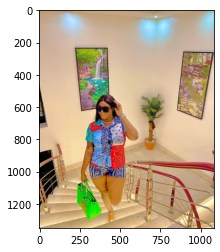

In [10]:
display_image(images[5])

In [11]:
#Convert all images to gray-scale
def convert_to_gray_scale(image):
    image = np.array(image, np.uint8)
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)


In [11]:
def get_new_image_dimen(image, new_dimen):
    width = image.width
    height = image.height
    new_width = 0
    new_height = 0
    aspect_ratio = width / height
    if width > height:
        new_width = new_dimen
        new_height = new_dimen / aspect_ratio
    else:
        new_height = new_dimen
        new_width = new_dimen * aspect_ratio
    return (new_width, new_height)


In [12]:
def pad_image(image, max_size):
    old_image_height, old_image_width, channels = image.shape
    # create new image of desired size and color (blue) for padding
    new_image_width = max_size
    new_image_height = max_size
    color = (0, 0, 0)
    result = np.full((new_image_height, new_image_width,
                      channels), color, dtype=np.uint8)
    # compute center offset
    x_center = (new_image_width - old_image_width) // 2
    y_center = (new_image_height - old_image_height) // 2
    # print(image)
    # copy img image into center of result image
    # result[y_center:y_center+old_image_height,x_center:x_center+old_image_width] = image
    result[0:old_image_height, 0:old_image_width] = image
    return result


In [13]:
# resize the image. The aspect ratio of the image is maintained.
for x in range(len(images)):
    new_dimen = 640;
    new_width, new_height = get_new_image_dimen(images[x], new_dimen)
    images[x] = images[x].resize((int(new_width), int(new_height))) #resize(images[x], new_width, new_height)


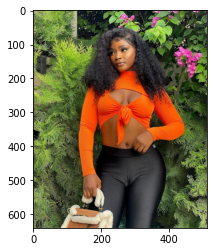

In [14]:
# display resized image
display_image(images[0])

In [15]:
#images are converted to numpy arrays to be padded.
for x in range(len(images)):
    images[x] = np.asarray(images[x])

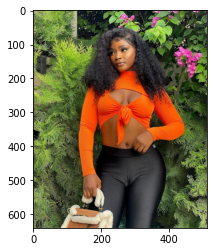

In [16]:
# display resized image
display_image(images[0])


In [17]:
# since the images do not have the same aspect ratios,
# the image is padded to have the same aspect ratios. 
for x in range(len(images)):
    images[x] = pad_image(images[x], 640)


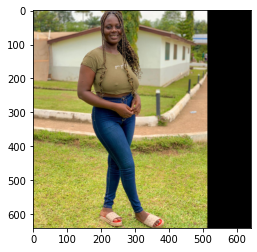

In [18]:
# display padded image
display_image(images[1])

In [19]:

# a low res image of the original images are created.
low_res_images = [None] * len(images)
for x in range(len(images)):
    new_dimen = 64
    ima = Image.fromarray(images[x])
    new_width, new_height = get_new_image_dimen(ima, new_dimen)
    low_res_images[x] = np.asarray(ima.resize((int(new_width), int(new_height))))


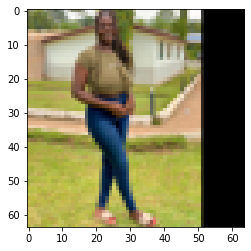

In [20]:
# display ycbcr image
display_image(low_res_images[1])


In [21]:
# convert to numpy arrays
low_res_images = np.array(low_res_images)
images = np.array(images)

In [22]:
# normalize arrays
low_res_images = low_res_images / 255
images = images / 255

In [ ]:
## Loading VGG16 model
base_model = VGG16(weights="imagenet", include_top=False,
                   input_shape=(96, 96, 3), input_tensor=Input(shape=(150, 150, 3)))
base_model.trainable = False  # Not trainable weights
base_model.summary()


In [23]:

#Encoder
encoder_input = Input(shape=(64, 64, 3,))
encoder_output = Conv2D(64, (3, 3), activation='relu',
                        padding='same', strides=2)(encoder_input)
encoder_output = Conv2D(128, (3, 3), activation='relu',
                        padding='same')(encoder_output)
encoder_output = Conv2D(128, (3, 3), activation='relu',
                        padding='same', strides=2)(encoder_output)
# encoder_output = MaxPooling2D(pool_size=2, strides=2)(encoder_output)
encoder_output = Conv2D(256, (3, 3), activation='relu',
                        padding='same')(encoder_output)
encoder_output = Conv2D(256, (3, 3), activation='relu',
                        padding='same', strides=2)(encoder_output)
encoder_output = Conv2D(512, (3, 3), activation='relu',
                        padding='same')(encoder_output)
# encoder_output = MaxPooling2D(pool_size=2, strides=2)(encoder_output)
encoder_output = Conv2D(512, (3, 3), activation='relu',
                        padding='same')(encoder_output)
encoder_output = Conv2D(256, (3, 3), activation='relu',
                        padding='same')(encoder_output)
# encoder_output = MaxPooling2D(pool_size=2, strides=2, name='encoder_end')(encoder_output)

# img_size_target = 240
# img_input = Input(shape=(img_size_target, img_size_target, 1))
# img_conc = Concatenate()([img_input, img_input, img_input])
# base_model = VGG16(input_tensor=img_conc)
# base_model.trainable = False  # Not trainable weights
# # base_model.summary()
# ## Loading VGG16 model
# # base_model = VGG16(weights="imagenet", include_top=False,
# #                    input_shape=(240, 240, 1,))
# # base_model.trainable = False  # Not trainable weights

# last_layer = base_model.get_layer('block5_conv3').output
#Decoder
decoder_output = Conv2D(128, (3, 3), activation='relu',
                        padding='same')(encoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = Conv2D(64, (3, 3), activation='relu',
                        padding='same')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = Conv2D(32, (3, 3), activation='relu',
                        padding='same')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = Conv2D(16, (3, 3), activation='relu',
                        padding='same')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = Conv2D(3, (3, 3), activation='sigmoid',
                        padding='same')(decoder_output)
decoder_output = UpSampling2D((5, 5))(decoder_output)
model = Model(inputs=encoder_input, outputs=decoder_output)
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
model.summary();


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 128)       147584    
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 256)       295168    
                                                                 
 conv2d_4 (Conv2D)           (None, 8, 8, 256)         590080    
                                                                 
 conv2d_5 (Conv2D)           (None, 8, 8, 512)         118016

2022-04-16 21:26:39.711552: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


 up_sampling2d_2 (UpSampling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 64, 64, 16)        4624      
                                                                 
 up_sampling2d_3 (UpSampling  (None, 128, 128, 16)     0         
 2D)                                                             
                                                                 
 conv2d_12 (Conv2D)          (None, 128, 128, 3)       435       
                                                                 
 up_sampling2d_4 (UpSampling  (None, 640, 640, 3)      0         
 2D)                                                             
                                                                 
Total params: 6,220,707
Trainable params: 6,220,707
Non-trainable params: 0
_________________________________________________________________


In [24]:
low_res_images.shape

(2049, 64, 64, 3)

In [46]:
# model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
model.fit(low_res_images, images,
          validation_split=0.1, epochs=30)


Epoch 1/30
58/58 [==============================] - 203s 3s/step - loss: 0.0171 - accuracy: 0.6643 - val_loss: 0.0178 - val_accuracy: 0.6529
Epoch 2/30
58/58 [==============================] - 198s 3s/step - loss: 0.0169 - accuracy: 0.6635 - val_loss: 0.0175 - val_accuracy: 0.6681
Epoch 3/30
58/58 [==============================] - 179s 3s/step - loss: 0.0168 - accuracy: 0.6602 - val_loss: 0.0175 - val_accuracy: 0.6542
Epoch 4/30
58/58 [==============================] - 181s 3s/step - loss: 0.0167 - accuracy: 0.6735 - val_loss: 0.0174 - val_accuracy: 0.6646
Epoch 5/30
58/58 [==============================] - 182s 3s/step - loss: 0.0167 - accuracy: 0.6656 - val_loss: 0.0176 - val_accuracy: 0.6537
Epoch 6/30
58/58 [==============================] - 188s 3s/step - loss: 0.0165 - accuracy: 0.6666 - val_loss: 0.0176 - val_accuracy: 0.6648
Epoch 7/30
58/58 [==============================] - 174s 3s/step - loss: 0.0166 - accuracy: 0.6641 - val_loss: 0.0173 - val_accuracy: 0.6574
Epoch 8/30
58

In [47]:
model.fit(low_res_images, images,
          validation_split=0.1, epochs=100)

Epoch 1/100
58/58 [==============================] - 167s 3s/step - loss: 0.0146 - accuracy: 0.6767 - val_loss: 0.0157 - val_accuracy: 0.6640
Epoch 2/100
58/58 [==============================] - 137s 2s/step - loss: 0.0146 - accuracy: 0.6765 - val_loss: 0.0156 - val_accuracy: 0.6537
Epoch 3/100
58/58 [==============================] - 126s 2s/step - loss: 0.0183 - accuracy: 0.6269 - val_loss: 0.0262 - val_accuracy: 0.5540
Epoch 4/100
58/58 [==============================] - 128s 2s/step - loss: 0.0210 - accuracy: 0.5647 - val_loss: 0.0171 - val_accuracy: 0.6234
Epoch 5/100
58/58 [==============================] - 123s 2s/step - loss: 0.0161 - accuracy: 0.6403 - val_loss: 0.0164 - val_accuracy: 0.6589
Epoch 6/100
58/58 [==============================] - 117s 2s/step - loss: 0.0152 - accuracy: 0.6570 - val_loss: 0.0157 - val_accuracy: 0.6422
Epoch 7/100
58/58 [==============================] - 120s 2s/step - loss: 0.0149 - accuracy: 0.6603 - val_loss: 0.0158 - val_accuracy: 0.6685
Epoch 

In [48]:
y_image = low_res_images[800]
output = model.predict(np.array([y_image]))


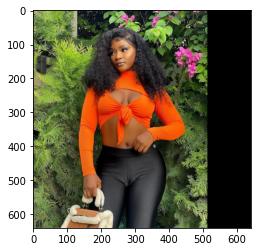

In [45]:
iu.display_image(images[0])

In [49]:
output[0]

array([[[7.8740859e-01, 7.8136021e-01, 7.4874032e-01],
        [7.8740859e-01, 7.8136021e-01, 7.4874032e-01],
        [7.8740859e-01, 7.8136021e-01, 7.4874032e-01],
        ...,
        [1.0592775e-05, 7.6016950e-05, 1.3217330e-04],
        [1.0592775e-05, 7.6016950e-05, 1.3217330e-04],
        [1.0592775e-05, 7.6016950e-05, 1.3217330e-04]],

       [[7.8740859e-01, 7.8136021e-01, 7.4874032e-01],
        [7.8740859e-01, 7.8136021e-01, 7.4874032e-01],
        [7.8740859e-01, 7.8136021e-01, 7.4874032e-01],
        ...,
        [1.0592775e-05, 7.6016950e-05, 1.3217330e-04],
        [1.0592775e-05, 7.6016950e-05, 1.3217330e-04],
        [1.0592775e-05, 7.6016950e-05, 1.3217330e-04]],

       [[7.8740859e-01, 7.8136021e-01, 7.4874032e-01],
        [7.8740859e-01, 7.8136021e-01, 7.4874032e-01],
        [7.8740859e-01, 7.8136021e-01, 7.4874032e-01],
        ...,
        [1.0592775e-05, 7.6016950e-05, 1.3217330e-04],
        [1.0592775e-05, 7.6016950e-05, 1.3217330e-04],
        [1.0592775e-05

In [43]:
images[800]

array([[[0.67058824, 0.63137255, 0.62745098],
        [0.71372549, 0.6745098 , 0.67058824],
        [0.74901961, 0.70980392, 0.70588235],
        ...,
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]],

       [[0.81176471, 0.77254902, 0.76862745],
        [0.78431373, 0.74509804, 0.74117647],
        [0.7372549 , 0.69803922, 0.69411765],
        ...,
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]],

       [[0.82352941, 0.78431373, 0.78039216],
        [0.92156863, 0.88235294, 0.87843137],
        [0.85882353, 0.81960784, 0.81568627],
        ...,
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]],

       ...,

       [[0.72156863, 0.61176471, 0.56862745],
        [0.72941176, 0.61960784, 0.57647059],
        [0.75686275, 0

In [274]:
output * 255

array([[[[128.8587  , 123.656746],
         [128.8587  , 123.656746],
         [128.8587  , 123.656746],
         ...,
         [129.28114 , 126.49314 ],
         [129.28114 , 126.49314 ],
         [129.28114 , 126.49314 ]],

        [[128.8587  , 123.656746],
         [128.8587  , 123.656746],
         [128.8587  , 123.656746],
         ...,
         [129.28114 , 126.49314 ],
         [129.28114 , 126.49314 ],
         [129.28114 , 126.49314 ]],

        [[128.8587  , 123.656746],
         [128.8587  , 123.656746],
         [128.8587  , 123.656746],
         ...,
         [129.28114 , 126.49314 ],
         [129.28114 , 126.49314 ],
         [129.28114 , 126.49314 ]],

        ...,

        [[ 86.65119 , 140.12514 ],
         [ 86.65119 , 140.12514 ],
         [ 86.65119 , 140.12514 ],
         ...,
         [128.06822 , 128.0179  ],
         [128.06822 , 128.0179  ],
         [128.06822 , 128.0179  ]],

        [[ 86.65119 , 140.12514 ],
         [ 86.65119 , 140.12514 ],
         [ 8

In [27]:
hr_image = output[0] * 255

In [30]:
output[0]


array([[[4.0607244e-01, 4.2298618e-01, 3.4342304e-01],
        [4.0607244e-01, 4.2298618e-01, 3.4342304e-01],
        [4.0607244e-01, 4.2298618e-01, 3.4342304e-01],
        ...,
        [1.3738871e-04, 1.8787682e-03, 3.5810471e-04],
        [1.3738871e-04, 1.8787682e-03, 3.5810471e-04],
        [1.3738871e-04, 1.8787682e-03, 3.5810471e-04]],

       [[4.0607244e-01, 4.2298618e-01, 3.4342304e-01],
        [4.0607244e-01, 4.2298618e-01, 3.4342304e-01],
        [4.0607244e-01, 4.2298618e-01, 3.4342304e-01],
        ...,
        [1.3738871e-04, 1.8787682e-03, 3.5810471e-04],
        [1.3738871e-04, 1.8787682e-03, 3.5810471e-04],
        [1.3738871e-04, 1.8787682e-03, 3.5810471e-04]],

       [[4.0607244e-01, 4.2298618e-01, 3.4342304e-01],
        [4.0607244e-01, 4.2298618e-01, 3.4342304e-01],
        [4.0607244e-01, 4.2298618e-01, 3.4342304e-01],
        ...,
        [1.3738871e-04, 1.8787682e-03, 3.5810471e-04],
        [1.3738871e-04, 1.8787682e-03, 3.5810471e-04],
        [1.3738871e-04

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


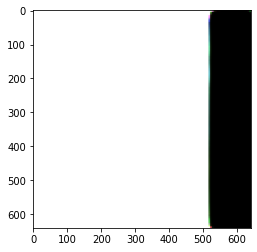

In [28]:
iu.display_image(hr_image)

In [182]:
def ycbcr2rgb(im):
    xform = np.array([[1, 0, 1.402], [1, -0.34414, -.71414], [1, 1.772, 0]])
    rgb = im.astype(np.float)
    rgb[:, :, [1, 2]] -= 128
    rgb = rgb.dot(xform.T)
    np.putmask(rgb, rgb > 255, 255)
    np.putmask(rgb, rgb < 0, 0)
    return np.uint8(rgb)


In [310]:
image = output[0] * 255
rgb_image =ycbcr2rgb(image)


/var/folders/kh/ldlc522d21lbvxg7zwz8yh8r0000gn/T/ipykernel_67439/1384511715.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  rgb = im.astype(np.float)


In [345]:
#test image
test_image = read_image(
    '/Users/ernestopoku-kwarteng/Documents/Pycharm Projects/Anaconda/Machine-Learning/deep-compression/data/a5121e3b72dcc615e492b126c9d388b6.jpeg')


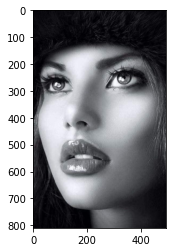

In [346]:
display_image(test_image)


In [347]:
# resize image
new_width, new_height = get_new_image_dimen(test_image, new_dimen)
test_image = test_image.resize((int(new_width), int(new_height)))


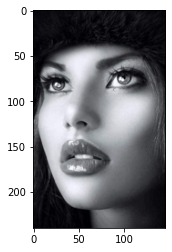

In [348]:
display_image(test_image)


In [349]:
test_image = np.asarray(test_image)


In [350]:
# pad image
test_image = pad_image(test_image, 240)


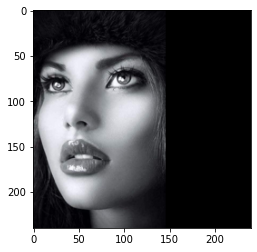

In [351]:
display_image(test_image)


In [352]:
# rgb np array is converted ycbcr color space
test_image = iu.rgb2ycbcr(test_image)


In [353]:
test_image = get_y_channel(test_image)


In [354]:
test_image.shape

(240, 240)

In [355]:
test_image = test_image / 255


In [356]:
output = model.predict(np.array([test_image]))

In [357]:
test_image = test_image.reshape(240, 240, 1)


In [358]:
test_cbcr_image = output[0] * 255
# y_image = y_image * 255
test_image = test_image * 255
ycbcr_image = combine_y_to_cbcr_channel(test_image, test_cbcr_image)


In [359]:
rgb_image = iu.ycbcr2rgb(ycbcr_image)

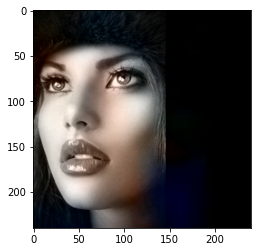

In [360]:
display_image(rgb_image)
